# 발화 개수

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
folder_path = "C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/"
sessions = os.listdir(folder_path)
session_paths = [folder_path+x for x in sessions]
### session_paths
# >>> ['C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/Session01',
#    'C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/Session02',
#     ...]

In [3]:
for i in range(len(session_paths)):
    temp = os.listdir(session_paths[i])
    temp_wav = [file for file in temp if file.endswith(".wav")]
    temp_txt = [file for file in temp if file.endswith("txt")]
#     print("num of wav", i," : ", len(temp_wav))
#     print("num of txt", i," : ", len(temp_txt))

# 모델 돌려보기 (wav만)

wav 파일 path 리스트 만들기

In [4]:
wav_set = []
for i in range(len(session_paths)):
    temp = os.listdir(session_paths[i])
    temp_wav = [session_paths[i]+"/"+file for file in temp if file.endswith(".wav")]
    wav_set.extend(temp_wav)
print(len(wav_set))

13462


## annotation (label) 데이터셋 가져오기

In [5]:
annotation_path = "C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/annotation/"
session_annotation_list = os.listdir(annotation_path)
session_annotation_paths = [annotation_path+x for x in session_annotation_list]

In [6]:
session_annotation_paths[0]

'C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/annotation/Sess01_eval.csv'

각 session##.csv 어떻게 나오는지 확인

In [7]:
session1_annotation_df = pd.read_csv(session_annotation_paths[0])
session1_annotation_df = session1_annotation_df.iloc[1:]
df = session1_annotation_df.iloc[:,[3,4,5,6]] # Segment ID, Total Evaluation, valence, Arousal Columns
df

,Segment ID,Total Evaluation,.1,.2
1,Sess01_script01_User002M_001,neutral,3.4,2.9
2,Sess01_script01_User002M_002,neutral,3.1,2.9
3,Sess01_script01_User002M_003,neutral,3.1,3
4,Sess01_script01_User002M_004,neutral,3.7,3.1
5,Sess01_script01_User001F_001,neutral,3.8,2.8
...,...,...,...,...
307,Sess01_script06_User001F_016,neutral,3.3,3.5
308,Sess01_script06_User002M_041,neutral,3.3,3.1
309,Sess01_script06_User002M_042,neutral,3,2.9
310,Sess01_script06_User002M_043,neutral,3,2.7


## Segment ID에 맞게 df 정리 및 합치기

           [   input  ]  [          output           ]
SegmentID - wav - text - Evaluation - Valence - Arousal   
		    file_path    categorical  int(1~5)  int(1~5)

df 불러오기 -> 자르기 -> (Evaluation label encoding 나중에) -> Valence int형으로 -> Arousal int형으로
-> 이전 df와 붙이기

Emotion: 중복된 감정이 있어 one-hot 하려고 나중에 처리함.

In [16]:
for i in range(len(session_annotation_paths)):
    temp_df = pd.read_csv(session_annotation_paths[i])
    temp_df = temp_df.iloc[1:]
    temp_df = temp_df.iloc[:,[3,4,5,6]] # Segment ID, Total Evaluation, valence, Arousal Columns
    temp_df = temp_df.rename(columns={" .1": "Valence", " .2": "Arousal"})
    # 나중에 one-hot 처리 temp_df["Total Evaluation"] = emotion_encoder.transform(temp_df["Total Evaluation"])
    temp_df[['Valence', 'Arousal']] = temp_df[['Valence', 'Arousal']].apply(pd.to_numeric)
    temp_df['Valence'] = temp_df['Valence'].astype(int)
    temp_df['Arousal'] = temp_df['Arousal'].astype(int)
    if i==0:
        prev_df = temp_df
    elif i!=0:
        dataset = pd.concat([prev_df, temp_df], axis=0)
        prev_df = dataset
    else: print("ERROR!")

In [17]:
len(dataset)

13462

In [18]:
dataset = dataset.reset_index(drop=True)
dataset.head()

,Segment ID,Total Evaluation,Valence,Arousal
0,Sess01_script01_User002M_001,neutral,3,2
1,Sess01_script01_User002M_002,neutral,3,2
2,Sess01_script01_User002M_003,neutral,3,3
3,Sess01_script01_User002M_004,neutral,3,3
4,Sess01_script01_User001F_001,neutral,3,2


In [19]:
from sklearn.preprocessing import LabelEncoder
#emotion_list = [기쁨, 놀람, 분노, 중립, 혐오, 공포, 슬픔]
emotion_encoder = LabelEncoder()
emotion_encoder.fit(dataset["Total Evaluation"])
print("Emotion classes check\n", emotion_encoder.classes_)

Emotion classes check
 ['angry' 'angry;disqust' 'angry;neutral' 'angry;neutral;disqust'
 'angry;neutral;disqust;fear;sad' 'disqust' 'fear' 'happy'
 'happy;angry;neutral' 'happy;fear' 'happy;neutral'
 'happy;neutral;disqust' 'happy;neutral;fear' 'happy;sad' 'happy;surprise'
 'happy;surprise;neutral' 'neutral' 'neutral;disqust'
 'neutral;disqust;sad' 'neutral;fear' 'neutral;sad' 'sad' 'surprise'
 'surprise;neutral']


In [20]:
wav_path = "C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/"
wav_path_list = []
for i in range(len(dataset['Segment ID'])):
    temp = dataset['Segment ID'][i]
    temp_class = temp[4:6]
    temp_path = wav_path+"Session"+temp_class+"/"+temp+".wav"
    wav_path_list.append(temp_path)

In [21]:
dataset['Wav path'] = wav_path_list
dataset = dataset[['Segment ID', 'Wav path', 'Total Evaluation', 'Valence', 'Arousal']]
dataset

,Segment ID,Wav path,Total Evaluation,Valence,Arousal
0,Sess01_script01_User002M_001,C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/Se...,neutral,3,2
1,Sess01_script01_User002M_002,C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/Se...,neutral,3,2
2,Sess01_script01_User002M_003,C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/Se...,neutral,3,3
3,Sess01_script01_User002M_004,C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/Se...,neutral,3,3
4,Sess01_script01_User001F_001,C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/Se...,neutral,3,2
...,...,...,...,...,...
13457,Sess40_script06_User079F_043,C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/Se...,neutral,3,3
13458,Sess40_script06_User079F_044,C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/Se...,neutral,2,3
13459,Sess40_script06_User079F_045,C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/Se...,neutral,2,3
13460,Sess40_script06_User079F_046,C:/Users/Gbook-230/Desktop/KEMDy20_v1_1/wav/Se...,neutral,2,3


## Audio 파일 읽어오기

In [22]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm

audio = []
print("START!")
for i in tqdm(range(len(dataset['Wav path']))):
    try: 
        midia_file = dataset['Wav path'][i]
        y, sr = librosa.load(midia_file, sr=16000) #길이는 임의로 1초로 함.
        audio.append(y)
    except:
        print("missing 1 file")
        print(i)
        continue

  0%|                                            | 0/13462 [00:00<?, ?it/s]

START!


100%|████████████████████████████████| 13462/13462 [02:18<00:00, 97.47it/s]


## Data Padding

In [23]:
audio_size = [x.shape[0] for x in audio]
print("train_size minimum: ", np.min(audio_size))
print("train_size Maximum: ", np.max(audio_size))
print("train_size mean: ", np.mean(audio_size))

train_size minimum:  10736
train_size Maximum:  563472
train_size mean:  94495.75040855742


In [24]:
# Set all data sizes to 95000.
pre_audio = [] #preprocessed audio data
for i in audio:
    if i.shape[0]>95000:
        tmp = i[:95000]
    elif i.shape[0]<95000:
        tmp = np.pad(i, (0, 95000-i.shape[0]), 'constant', constant_values=0)
    elif i.shape[0]==95000:
        tmp = i
    else:
        print("ERROR!")
        print(i.shape)
        print(i)
    pre_audio.append(tmp)

In [25]:
#들어보기
ipd.Audio(pre_audio[0], rate=sr)

In [22]:
print(len(pre_audio))
print(len(pre_audio[0]))

13462
95000


In [23]:
type(pre_audio[0])

numpy.ndarray

In [24]:
audio_np = np.array(pre_audio)

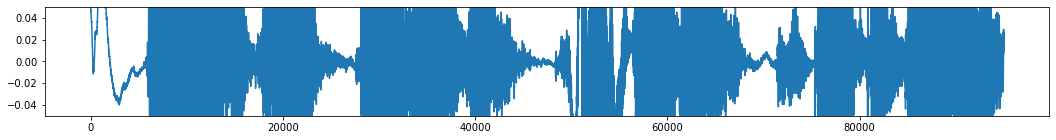

AttributeError: module 'matplotlib' has no attribute 'pyplot'

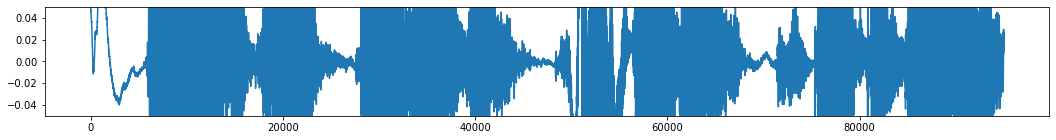

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [44]:
import matplotlib.pyplot as plt
for idx in range(0, 3):
    plt.figure(figsize=(18,2))
    plt.plot(audio_np[idx])
    plt.ylim((-0.05, 0.05))
    plt.show()

In [26]:
from sklearn.model_selection import train_test_split
train_audio, test_audio, train_labels, test_labels = train_test_split(audio_np, dataset['Valence'], test_size=0.3, random_state=777)

In [27]:
train_audio_np = np.array(train_audio)
train_labels_np = np.array(train_labels, np.int16)
test_audio_np = np.array(test_audio, np.float32)
test_labels_np = np.array(test_labels, np.int16)

In [28]:
# print(train_labels_np[1])
# ipd.Audio(train_audio_np[1], rate=sr)

# Convert np to MFCC

In [29]:
print(len(train_audio_np))
print(len(train_labels))
print(len(test_audio_np))
print(len(test_labels))

9423
9423
4039
4039


In [30]:
train_mfcc = []
for y in tqdm(train_audio_np):
    ret = librosa.feature.mfcc(y=y, sr=sr)
    train_mfcc.append(ret)

test_mfcc = []
for y in tqdm(test_audio_np):
    ret = librosa.feature.mfcc(y=y, sr=sr)
    test_mfcc.append(ret)

100%|██████████████████████████████████| 4039/4039 [01:42<00:00, 39.52it/s]


In [31]:
train_mfcc_np = np.array(train_mfcc, np.float32)
test_mfcc_np = np.array(test_mfcc, np.float32)

print(train_mfcc_np.shape, train_labels_np.shape)
print(test_mfcc_np.shape, test_labels_np.shape)

(9423, 20, 186) (9423,)
(4039, 20, 186) (4039,)


In [32]:
## convert 3dims to 2dims
train_mfcc_np = train_mfcc_np.reshape(9423, 20*186)
test_mfcc_np = test_mfcc_np.reshape(4039, 20*186)

print(train_mfcc_np.shape)
print(train_labels_np.shape)
print(test_mfcc_np.shape)
print(test_labels_np.shape)

(9423, 3720)
(9423,)
(4039, 3720)
(4039,)


## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_mfcc_np, train_labels_np)
pred = LR.predict(test_mfcc_np)
acc = accuracy_score(pred, test_labels_np)
print(acc)

0.5427085912354543


C:\Users\Gbook-230\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## CNN Classification

In [34]:
train_mfcc_np = np.array(train_mfcc, np.float32)
test_mfcc_np = np.array(test_mfcc, np.float32)

train_mfcc_array = np.expand_dims(train_mfcc_np, -1)
test_mfcc_array = np.expand_dims(test_mfcc_np, -1)

print(train_mfcc_array.shape)
print(train_labels_np.shape)
print(test_mfcc_array.shape)
print(test_labels_np.shape)

(9423, 20, 186, 1)
(9423,)
(4039, 20, 186, 1)
(4039,)


In [35]:
from keras.utils import to_categorical

train_labels_cat = to_categorical(train_labels_np)
test_labels_cat = to_categorical(test_labels_np)

print(train_labels_cat.shape)
print(test_labels_cat.shape)

(9423, 5)
(4039, 5)


In [36]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.layers import Conv2D, MaxPool2D, Flatten

def CNN_model_build():
    model = Sequential()
    
    input = Input(shape=(20, 186, 1))
    output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
    output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)
    
    output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
    output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)
    
    output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
    output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)
    
    output = Flatten()(output)
    output=Dense(512, activation='relu')(output)
    output=Dense(256, activation='relu')(output)
    output=Dense(128, activation='relu')(output)
    
    output=Dense(5, activation='softmax')(output)
    
    model = Model(inputs=[input], outputs=output)
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['acc'])
    return model

In [37]:
CNN_model = CNN_model_build()
CNN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 186, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 186, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 93, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 93, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 47, 256)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 47, 512)        118016

In [38]:
history = CNN_model.fit(train_mfcc_array, train_labels_cat, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
236/236 [==============================] - 138s 577ms/step - loss: 1.9543 - acc: 0.5305 - val_loss: 0.8627 - val_acc: 0.5225
Epoch 2/5
236/236 [==============================] - 138s 584ms/step - loss: 0.8288 - acc: 0.5545 - val_loss: 0.8656 - val_acc: 0.5268
Epoch 3/5
236/236 [==============================] - 137s 581ms/step - loss: 0.8235 - acc: 0.5602 - val_loss: 0.8369 - val_acc: 0.5501
Epoch 4/5
 11/236 [>.............................] - ETA: 2:02 - loss: 0.8073 - acc: 0.5938

KeyboardInterrupt: 

In [ ]:
def plot_history(history_dict):
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(loss)+1)
    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(epochs, loss, 'b--', label='train_loss')
    ax1.plot(epochs, val_loss, 'r', label='val_loss')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.grid()
    ax1.legend()
    
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(epochs, acc, 'b--', label='train_accuracy')
    ax2.plot(epochs, val_acc, 'r', label='val_accuracy')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("accuarcy")
    ax2.grid()
    ax2.legend()
    
    plt.show()

In [ ]:
plot_history(history.history)

In [ ]:
CNN_model.evaluate(test_mfcc_array, test_labels_cat)

In [ ]:
pred = CNN_model(test_mfcc_array)
## classification_report
from sklearn.metrics import classification_report
y_test = test_labels_np
preds_list = pred.numpy().argmax(-1)
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)
# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

## CORAL CNN

In [41]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.layers import Conv2D, MaxPool2D, Flatten
import coral_ordinal as coral

def coral_CNN_model_build():
    model = Sequential()
    
    input = Input(shape=(20, 186, 1))
    output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
    output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)
    
    output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
    output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)
    
    output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
    output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)
    
    output = Flatten()(output)
    output=Dense(512, activation='relu')(output)
    output=Dense(256, activation='relu')(output)
    output=Dense(128, activation='relu')(output)
    
    #output=Dense(3, activation='sigmoid')(output)
    output=coral.CoralOrdinal(num_classes=5)(output)
    
    model = Model(inputs=[input], outputs=output)
    model.compile(optimizer='adam',
                 loss = coral.OrdinalCrossEntropy(3),
                 metrics=['acc'])
    return model

In [42]:
coral_CNN_model = coral_CNN_model_build()
coral_CNN_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 186, 1)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 186, 128)      1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 93, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 93, 256)       295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 47, 256)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 47, 512)        1180

In [43]:
history = coral_CNN_model.fit(train_mfcc_array, train_labels_np, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/ordinal_crossentropy/mul/BroadcastGradientArgs' defined at (most recent call last):
    File "C:\Users\Gbook-230\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Gbook-230\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
      app.start()
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Gbook-230\anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\Gbook-230\anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\Gbook-230\anaconda3\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-43-4d2e1a913dd3>", line 1, in <module>
      history = coral_CNN_model.fit(train_mfcc_array, train_labels_np, epochs=5, batch_size=32, validation_split=0.2)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\keras\engine\training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\Gbook-230\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/ordinal_crossentropy/mul/BroadcastGradientArgs'
Incompatible shapes: [32,4] vs. [32,2]
	 [[{{node gradient_tape/ordinal_crossentropy/mul/BroadcastGradientArgs}}]] [Op:__inference_train_function_7963]

In [ ]:
def plot_history(history_dict):
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(loss)+1)
    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(epochs, loss, 'b--', label='train_loss')
    ax1.plot(epochs, val_loss, 'r', label='val_loss')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.grid()
    ax1.legend()
    
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(epochs, acc, 'b--', label='train_acc')
    ax2.plot(epochs, val_acc, 'r', label='val_acc')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.grid()
    ax2.legend()
    
    plt.show()

In [ ]:
plot_history(history.history)

In [ ]:
# Generate predictions - initially these are cumulative logits.
preds = coral_CNN_model.predict(test_mfcc_array)
#print(preds)
# Convert cumulative logits to probabilities for each class aka rank or label.
probs = pd.DataFrame(coral.ordinal_softmax(preds).numpy())

In [ ]:
from scipy import special

# Compare to logit-based cumulative probs
cum_probs = pd.DataFrame(preds).apply(special.expit)
# Calculate the labels using the style of Cao et al.
pred_labels = cum_probs.apply(lambda x: x > 0.5).sum(axis = 1)
print("Accuracy of label:", np.mean(pred_labels == test_labels_np))

In [ ]:
# These do not correspond with what we get from the model evaluation. Something must be off in one of these.
print("Mean absolute label error", np.mean(np.abs(pred_labels - test_labels_np)))
print("Root mean squared label error:", np.sqrt(np.mean(np.square(pred_labels - test_labels_np))))

In [ ]:
pred = CNN_model(test_mfcc_array)
## classification_report
from sklearn.metrics import classification_report
y_test = test_labels_np
preds_list = pred_labels
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)
# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()